In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neurondata-th-anna1/ANNA1/Neuron Image Data ANNA1 (2).xlsx
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0074.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0077.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0058.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0053.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0006.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0070.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0057.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0044.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0078.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0011.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0056.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0019.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0008.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0061.jpg
/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images/0082.j

## README:

Our neuron-counting model is based off of the Object Classification example notebook from https://www.tensorflow.org/hub/tutorials/object_detection. We adapted the basic functions (build_dataset, build, compile, and train model, and print accuracy metric charts) to our goal of predicting the number of neurons in an image of cell tissue. 

When adding/removing images from the dataset, ensure that `data_dir` is set to the directory of the original images, and that `neuron_labels` is an array of the integer counts associated with each image in alphanumeric order. Changing `NUM_AUGMENTATIONS` will change the number of rotated copies of each image used to supplement the dataset, and will automatically update the image labels to match the supplemented dataset.

In [2]:
import itertools
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import random

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.6.4
Hub version: 0.12.0
GPU is available


2022-12-09 15:06:23.390100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 15:06:23.491875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 15:06:23.492793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# Select feature extractor model

#model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']
model_name = "efficientnetv2-s-21k"

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model: efficientnetv2-s-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2
Input size (384, 384)


In [4]:
# Get directory of original, non-augmented dataset
data_dir = '/kaggle/input/neurondata-th-anna1/ANNA1/'

In [5]:
# Generate neuron count labels that align with the augmented dataset

NUM_AUGMENTATIONS = 4

# The neuron counts for each image in the numeric order of each image filename
neuron_labels = [70, 43, 12, 10, 14, 20, 87, 63, 75, 22, 13, 21, 18, 95, 51, 66, 11, 25, 20, 63, 45, 55, 25, 17, 13, 81,74, 70, 48, 86, 85, 20, 18, 16, 45, 37, 53, 11, 8, 11, 35, 34, 50, 9, 11, 37, 23, 9, 7, 31, 32, 28, 50, 33, 37, 25, 55, 44, 37, 10, 17, 12, 19,22, 9, 41, 38, 36, 6, 12, 23, 31, 16, 32, 12, 8, 13, 81, 77, 80, 20, 11, 24, 91, 90, 94, 32, 61]
augmented_neuron_labels = []

for i in neuron_labels:
    for j in range(NUM_AUGMENTATIONS):
        augmented_neuron_labels.append(i)
    
print(augmented_neuron_labels)

[70, 70, 70, 70, 43, 43, 43, 43, 12, 12, 12, 12, 10, 10, 10, 10, 14, 14, 14, 14, 20, 20, 20, 20, 87, 87, 87, 87, 63, 63, 63, 63, 75, 75, 75, 75, 22, 22, 22, 22, 13, 13, 13, 13, 21, 21, 21, 21, 18, 18, 18, 18, 95, 95, 95, 95, 51, 51, 51, 51, 66, 66, 66, 66, 11, 11, 11, 11, 25, 25, 25, 25, 20, 20, 20, 20, 63, 63, 63, 63, 45, 45, 45, 45, 55, 55, 55, 55, 25, 25, 25, 25, 17, 17, 17, 17, 13, 13, 13, 13, 81, 81, 81, 81, 74, 74, 74, 74, 70, 70, 70, 70, 48, 48, 48, 48, 86, 86, 86, 86, 85, 85, 85, 85, 20, 20, 20, 20, 18, 18, 18, 18, 16, 16, 16, 16, 45, 45, 45, 45, 37, 37, 37, 37, 53, 53, 53, 53, 11, 11, 11, 11, 8, 8, 8, 8, 11, 11, 11, 11, 35, 35, 35, 35, 34, 34, 34, 34, 50, 50, 50, 50, 9, 9, 9, 9, 11, 11, 11, 11, 37, 37, 37, 37, 23, 23, 23, 23, 9, 9, 9, 9, 7, 7, 7, 7, 31, 31, 31, 31, 32, 32, 32, 32, 28, 28, 28, 28, 50, 50, 50, 50, 33, 33, 33, 33, 37, 37, 37, 37, 25, 25, 25, 25, 55, 55, 55, 55, 44, 44, 44, 44, 37, 37, 37, 37, 10, 10, 10, 10, 17, 17, 17, 17, 12, 12, 12, 12, 19, 19, 19, 19, 22, 22,

In [6]:
# Create data augmentation model. Write augmented images to output directory. Chose to
# include only rotation since translation and zoom could change the # of neurons 
# visible in the image
# d_aug model from https://www.educba.com/keras-data-augmentation/

d_aug = tf.keras.Sequential([
tf.keras.layers.RandomRotation(40),
#tf.keras.layers.RandomTranslation(0, 0.2),
#tf.keras.layers.RandomTranslation(0.2, 0),
#tf.keras.layers.RandomZoom(0.2, 0.2),
#tf.keras.layers.RandomFlip(mode="horizontal")
])

output_dir = "/kaggle/working/"

if not os.path.exists(os.path.join(output_dir, "images/")): 
    print("Creating images folder...")
    output_dir = os.path.join(output_dir, "images/")
    os.mkdir(output_dir)
else:
    output_dir = "/kaggle/working/images/"
    # Clear output dir
    print("Clearing output directory...")
    for f in os.listdir(output_dir):
        if (f[0] != "." and f[0] != "_" and not os.path.isdir(f)):
            os.remove(os.path.join(output_dir, f))
         
print("Performing data augmentation...")
img_dir = "/kaggle/input/neurondata-th-anna1/ANNA1/ANNA1 Images"
num_images = len(os.listdir(img_dir))
# img_count = 0
# stop_point = num_images - num_images * 0.20
# print("Stop point " + str(stop_point))

# Save augmented images to dir
for j in os.listdir(img_dir): 
    image = tf.keras.preprocessing.image.load_img(img_dir + "/" + str(j))

    # Only augment images if part of training split
#     if (img_count < stop_point):   
    for i in range(NUM_AUGMENTATIONS):
        a_img = d_aug(image)

        # Save image to output
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        filename = output_dir
        filename += str(j)[:4] + "-" + str(i) + ".jpg"
        tf.keras.preprocessing.image.save_img(filename, a_img)
            
#     else: 
#         # Save image to output
#         image_array = tf.keras.preprocessing.image.img_to_array(image)
#         filename = output_dir
#         filename += str(j)
#         tf.keras.preprocessing.image.save_img(filename, image)
#         print("Not augmenting " + str(filename))
        
#     img_count = img_count + 1
        
print("Num images processed:" + str(num_images))

2022-12-09 15:06:23.605578: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 15:06:23.605935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 15:06:23.606723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 15:06:23.607367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Creating images folder...
Performing data augmentation...
Num images processed:88


In [7]:
# Split images into training and validation datasets, and format as a 
# Tensorflow dataset

def build_dataset(subset):
    return tf.keras.utils.image_dataset_from_directory(
      #data_dir,
      #output_dir,
      "/kaggle/working/",  
      shuffle= False,
      validation_split=.20,
      subset=subset,
      #labels=neuron_labels,
      labels=augmented_neuron_labels,
      label_mode="int",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      #seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
print("train size", train_size)
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
print("val_ds size " + str(valid_size))
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 352 files belonging to 1 classes.
Using 282 files for training.
train size 282
Found 352 files belonging to 1 classes.
Using 70 files for validation.
val_ds size 70


In [8]:
do_fine_tuning = True

# Custom vanilla network structure that takes model_handle as feature extractor
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
   
    # Austin's Model --------------------------------------
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(640, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(320, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(160, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1,
                          kernel_regularizer=tf.keras.regularizers.l2(0.01))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              20331360  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 320)               205120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
___________________

In [9]:
# Compiler with custom settings
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['MeanSquaredError'])

In [10]:
# Train the model

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE

hist = model.fit(
    train_ds,
    epochs=50, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    shuffle=True
    ).history

Epoch 1/50


2022-12-09 15:07:24.711005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-09 15:07:44.561487: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17/17 [==============================] - 35s 518ms/step - loss: 1101.5232 - mean_squared_error: 1086.7614 - val_loss: 794.4879 - val_mean_squared_error: 779.7200
Epoch 2/50
17/17 [==============================] - 7s 401ms/step - loss: 731.6808 - mean_squared_error: 716.8536 - val_loss: 1522.3553 - val_mean_squared_error: 1507.4872
Epoch 3/50
17/17 [==============================] - 7s 427ms/step - loss: 716.0255 - mean_squared_error: 701.1215 - val_loss: 788.7609 - val_mean_squared_error: 773.8214
Epoch 4/50
17/17 [==============================] - 7s 407ms/step - loss: 622.8822 - mean_squared_error: 607.9276 - val_loss: 1152.5238 - val_mean_squared_error: 1137.5416
Epoch 5/50
17/17 [==============================] - 7s 401ms/step - loss: 513.7234 - mean_squared_error: 498.7278 - val_loss: 617.0084 - val_mean_squared_error: 601.9784
Epoch 6/50
17/17 [==============================] - 7s 408ms/step - loss: 522.1288 - mean_squared_error: 507.0939 - val_loss: 566.8813 - val_mean_squared_

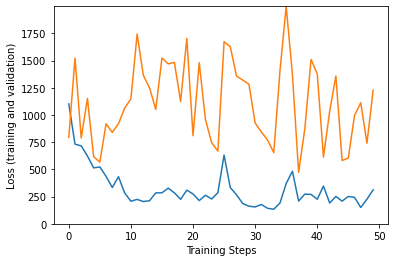

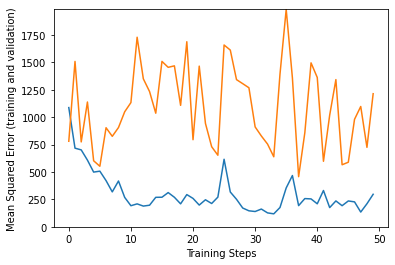

In [11]:
# Print training and validation metric graphs

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
cap = max(max(hist["loss"]), max(hist["val_loss"]))
plt.ylim([0,max(hist["val_loss"])])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Mean Squared Error (training and validation)")
plt.xlabel("Training Steps")
cap = max(max(hist["mean_squared_error"]), max(hist["val_mean_squared_error"]))
plt.ylim([0,max(hist["val_mean_squared_error"])])
plt.plot(hist["mean_squared_error"])
plt.plot(hist["val_mean_squared_error"])

In [12]:
# Print all predicted values and true values:

print("All predictions from validation set of size", valid_size)
true_avg = 0
pred_avg = 0

for x, y in val_ds:
    index = 0
    for i in y.numpy():
        image = x[index, :, :, :]
        pred_y = model.predict(np.expand_dims(image, axis=0))[0][0]
        print("True y:", i, " Predicted y:", pred_y)
        index = index + 1
        true_avg += i
        pred_avg += pred_y
        
true_avg = true_avg / valid_size
pred_avg = pred_avg / valid_size
print("Average of true counts: " + str(true_avg))
print("Average of predicted counts: " + str(pred_avg))

All predictions from validation set of size 70
True y: 23  Predicted y: 18.623232
True y: 23  Predicted y: 21.666159
True y: 31  Predicted y: 25.33505
True y: 31  Predicted y: 29.9248
True y: 31  Predicted y: 24.459473
True y: 31  Predicted y: 21.707813
True y: 16  Predicted y: 19.65256
True y: 16  Predicted y: 18.114893
True y: 16  Predicted y: 17.807459
True y: 16  Predicted y: 15.49528
True y: 32  Predicted y: 24.250257
True y: 32  Predicted y: 27.078764
True y: 32  Predicted y: 19.682442
True y: 32  Predicted y: 26.352776
True y: 12  Predicted y: 10.311993
True y: 12  Predicted y: 12.794999
True y: 12  Predicted y: 10.161729
True y: 12  Predicted y: 9.699428
True y: 8  Predicted y: 10.558574
True y: 8  Predicted y: 11.364731
True y: 8  Predicted y: 7.727606
True y: 8  Predicted y: 12.091711
True y: 13  Predicted y: 18.800817
True y: 13  Predicted y: 22.93385
True y: 13  Predicted y: 20.529625
True y: 13  Predicted y: 21.262028
True y: 81  Predicted y: 24.628452
True y: 81  Predicte

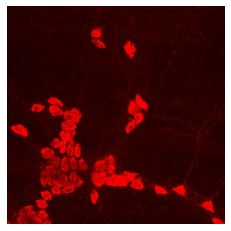

Index 11, True y: 32  Predicted y: 27.078764


In [13]:
# Print out one random sample image from validation set

# index of sample image
sample = random.randrange(0, 16)
sample = 11

x, y = next(iter(val_ds))   # Gets first element of 16 images from val_ds
image = x[sample, :, :, :]
true_y = y[sample].numpy()
plt.imshow(image)
plt.axis('off')
plt.show()
print("Index " + str(sample) + ", True y:", true_y, " Predicted y:", model.predict(np.expand_dims(image, axis=0))[0][0])
